# LMXBovespa - Previsão do Fechamento Diário da IBOVESPA

* Obs: LMXBovespa é apenas o nome dado pelo autor programa. Não tem relação com nenhum índice ou empresa.

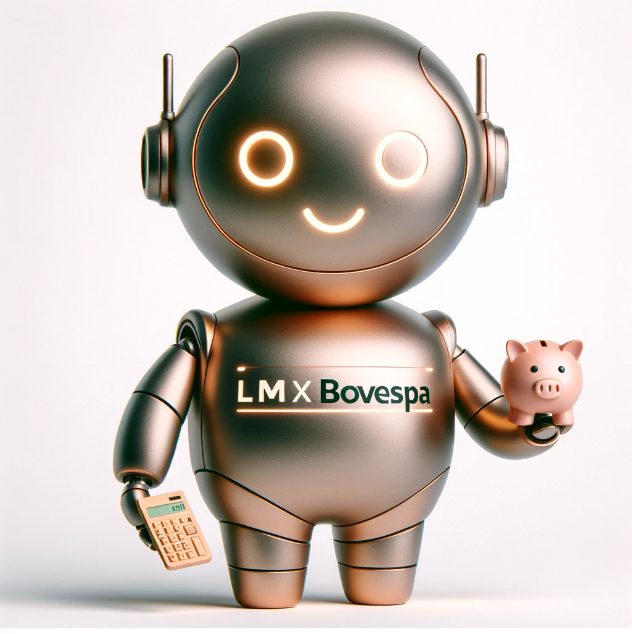

## Índice
1. [Introdução](#Introdução)
2. [Coleta e Preparação dos Dados](#Coleta-e-Preparação-dos-Dados)
3. [Análise Exploratória de Dados (EDA)](#Análise-Exploratória-de-Dados-EDA)
4. [Modelagem](#Modelagem)
5. [Resultados](#Resultados)
6. [Conclusão e Recomendações](#Conclusão-e-Recomendações)

## 1. Introdução
Na era da informação em que vivemos, a capacidade de antecipar movimentos no mercado financeiro pode ser o diferencial entre o sucesso e o fracasso de investimentos. O índice IBOVESPA, como principal termômetro do mercado de ações brasileiro, desempenha um papel crucial nas decisões de investimento, refletindo não apenas a saúde econômica do Brasil, mas também as tendências globais que afetam diretamente os investidores.<br>
Este projeto visa utilizar técnicas avançadas de modelagem preditiva para desenvolver um modelo capaz de prever os valores de fechamento diário da IBOVESPA.

##2. Coleta e Preparação dos Dados

Os dados utilizados são da fonte https://br.investing.com/indices/bovespa-historical-data<br>
Foi considerado o período **Diário**, de 02/02/2021 a 20/02/2024;<br>
Para o algoritmo funcionar, a base de dados deve baixada da fonte e ser disponibilizada nesse ambiente.

In [ ]:
import pandas as pd
# Substitua o texto em vermelho pelo caminho onde você salvou o arquivo CSV
dados_ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')

Após importar a base, é realizado o tratamento das variáveis que serão utilizadas para o treinamento do modelo

In [ ]:
# Convertendo a coluna 'Data' para datetime e ordenando o DataFrame pela data
dados_ibovespa['Data'] = pd.to_datetime(dados_ibovespa['Data'], format='%d.%m.%Y')
dados_ibovespa.sort_values('Data', inplace=True)

# Definindo a coluna 'Data' como índice do DataFrame
dados_ibovespa.set_index('Data', inplace=True)

Após tratar a coluna Data e definí-la como índice, surge um problema:
A bolsa de valores não opera aos feriados e finais de semana, sendo assim, os dados apresentam lacunas nas séries temporais para as novas datas, conforme demonstrado abaixo:

Note que a próxima data depois de 2021-02-12 é 2021-02-17

In [ ]:

dados_ibovespa.head(15)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2021-02-01,117.518,115.093,117.862,115.093,"8,72M","2,13%"
2021-02-02,118.234,117.520,119.805,117.519,"11,63M","0,61%"
2021-02-03,119.725,118.235,120.210,118.234,"8,70M","1,26%"
2021-02-04,119.261,119.728,120.560,118.918,"8,10M","-0,39%"
2021-02-05,120.240,119.261,121.117,119.261,"8,21M","0,82%"
2021-02-08,119.696,120.239,120.844,119.140,"8,62M","-0,45%"
2021-02-09,119.472,119.696,119.975,118.246,"7,91M","-0,19%"
2021-02-10,118.435,119.472,119.738,117.970,"8,64M","-0,87%"
2021-02-11,119.300,118.440,120.283,118.440,"7,57M","0,73%"


Para corrigir esse problema, será criado um range de datas, partindo da data mínima até a data máxima da base de dados

In [ ]:
start = dados_ibovespa.index.min()
end = dados_ibovespa.index.max()
date_range = pd.date_range(start=start, end=end)
dados_ibovespa = dados_ibovespa.reindex(date_range)
dados_ibovespa.index.rename('Data', inplace=True)

Porém, quando isso é realizado, outro problema surge, em decorrência da operação anterior: as características correspondentes às novas datas inseridas estão nulas.

In [ ]:
dados_ibovespa.isnull().sum()

Último      355
Abertura    355
Máxima      355
Mínima      355
Vol.        355
Var%        355
dtype: int64

Para preencher as lacunas existentes nos dados, optaremos por utilizar os valores do dia imediatamente anterior ao que apresenta ausência de informação. Esta escolha se justifica pelo entendimento de que, em dias em que a bolsa de valores não teve operações, os valores tendem a permanecer estáveis, assemelhando-se aos registrados no último dia de negociação. Assim, essa abordagem garante uma continuidade lógica e coerente nos dados, crucial para a integridade da análise subsequente.

In [ ]:
dados_ibovespa['Último'] = dados_ibovespa[['Último']].fillna(method='ffill')
dados_ibovespa['Abertura'] = dados_ibovespa[['Abertura']].fillna(method='ffill')
dados_ibovespa['Mínima'] = dados_ibovespa[['Mínima']].fillna(method='ffill')
dados_ibovespa['Máxima'] = dados_ibovespa[['Máxima']].fillna(method='ffill')
dados_ibovespa = dados_ibovespa[['Último','Abertura', 'Mínima', 'Máxima']]

Além disso, para a previsão do preço de fechamento, utilizaremos exclusivamente o preço de abertura, o mínimo e o máximo. A justificativa para esta seleção será esclarecida em etapas posteriores deste documento. Por ora, é importante reter essa estratégia, que desempenha um papel crucial na construção do nosso modelo preditivo.

## 3. Análise Exploratória de Dados (EDA)

Antes de mergulharmos nas complexidades da modelagem preditiva, é crucial iniciar nossa jornada com uma sólida compreensão dos dados à nossa disposição. A Análise Exploratória de Dados (EDA) é o alicerce sobre o qual construímos nosso entendimento do índice IBOVESPA, permitindo-nos desvendar as nuances e padrões que moldam seus movimentos diários.

O ponto de partida essencial é compreender o comportamento da série temporal, identificando a presença de elementos como tendências, sazonalidades e ruídos

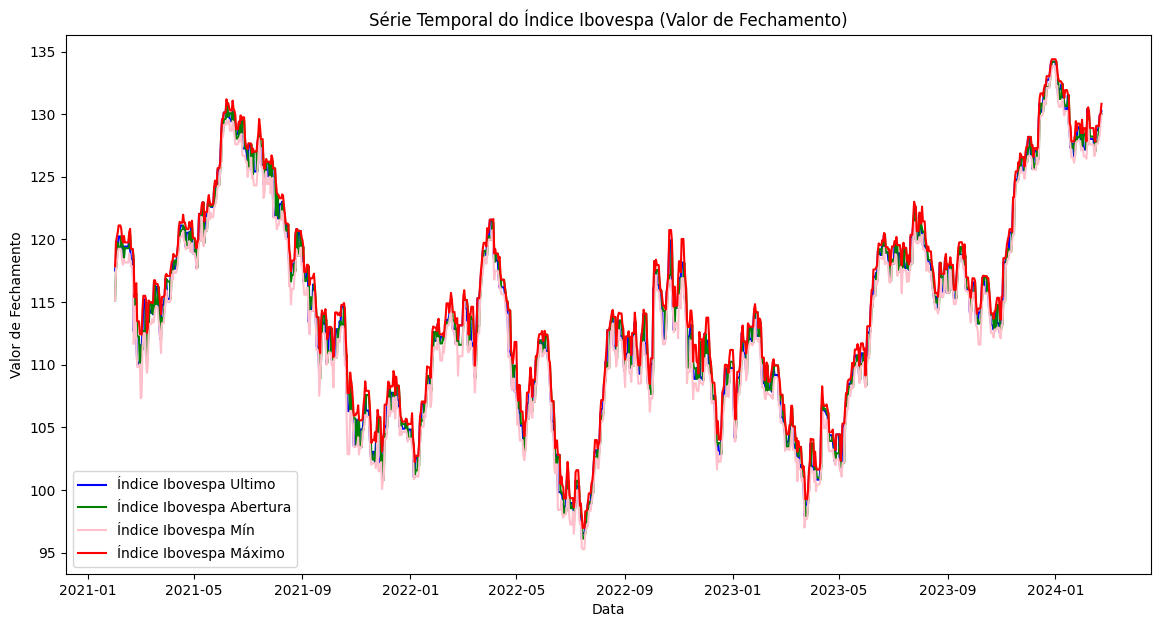

ADF Statistic: -1.8953372665793835
p-value: 0.33425777709212273
A série temporal não é estacionária e pode precisar de diferenciação.


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Visualização da série temporal da coluna 'Último'
plt.figure(figsize=(14, 7))
plt.plot(dados_ibovespa.index, dados_ibovespa['Último'], label='Índice Ibovespa Ultimo', color='blue')
plt.plot(dados_ibovespa.index, dados_ibovespa['Abertura'], label='Índice Ibovespa Abertura', color='green')
plt.plot(dados_ibovespa.index, dados_ibovespa['Mínima'], label='Índice Ibovespa Mín', color='pink')
plt.plot(dados_ibovespa.index, dados_ibovespa['Máxima'], label='Índice Ibovespa Máximo', color='red')
plt.title('Série Temporal do Índice Ibovespa (Valor de Fechamento)')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

# Teste Dickey-Fuller para verificar a estacionariedade da série temporal
resultado_adfuller = adfuller(dados_ibovespa['Último'], autolag='AIC')
adf_statistic = resultado_adfuller[0]
p_value = resultado_adfuller[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Se o p-valor for menor que 0.05, a série é estacionária
if p_value < 0.05:
    print("A série temporal é estacionária.")
else:
    print("A série temporal não é estacionária e pode precisar de diferenciação.")

Mas o que aconteceu aqui? Vamos à explicação:<br>
O gráfico gerado ilustra a trajetória dos valores de fechamento (representados pela coluna "último"), em paralelo com os valores do preço de abertura, mínimo e máximo do índice. É importante manter essa observação em mente por enquanto.<br>
Adicionalmente, realizamos uma verificação para determinar se a série temporal é estacionária. Isso se deve ao fato de que, em séries estacionárias, torna-se mais simples identificar correlações com observações passadas.<br>
Para avaliar a estacionaridade da série, recorremos ao teste estatístico ADF (Augmented Dickey-Fuller), que parte do princípio de que a série temporal é não estacionária como sua hipótese nula. Diante de um p-value de 0.32, não conseguimos rejeitar a hipótese nula, indicando que a série temporal é, de fato, não estacionária. Portanto, concluímos que será necessário aplicar diferenciação à série para possibilitar uma análise mais aprofundada.

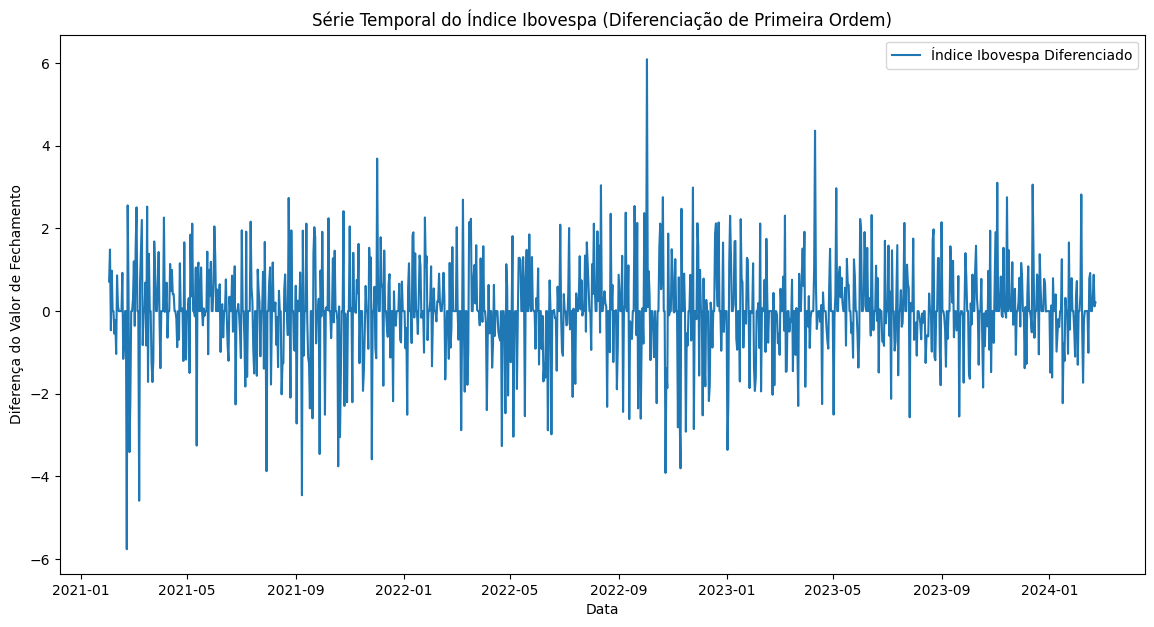

ADF Statistic (Diferenciada): -34.219407406229735
p-value (Diferenciada): 0.0
A série temporal diferenciada é estacionária.


In [ ]:
# Diferenciação da série temporal
dados_ibovespa['Último_dif'] = dados_ibovespa['Último'].diff().dropna()

# Visualização da série temporal diferenciada
plt.figure(figsize=(14, 7))
plt.plot(dados_ibovespa.index, dados_ibovespa['Último_dif'], label='Índice Ibovespa Diferenciado')
plt.title('Série Temporal do Índice Ibovespa (Diferenciação de Primeira Ordem)')
plt.xlabel('Data')
plt.ylabel('Diferença do Valor de Fechamento')
plt.legend()
plt.show()

# Teste Dickey-Fuller na série temporal diferenciada
resultado_adfuller_dif = adfuller(dados_ibovespa['Último_dif'].dropna(), autolag='AIC')
adf_statistic_dif = resultado_adfuller_dif[0]
p_value_dif = resultado_adfuller_dif[1]

print(f'ADF Statistic (Diferenciada): {adf_statistic_dif}')
print(f'p-value (Diferenciada): {p_value_dif}')

# Se o p-valor for menor que 0.05, a série diferenciada é estacionária
if p_value_dif < 0.05:
    print("A série temporal diferenciada é estacionária.")
else:
    print("A série temporal diferenciada ainda não é estacionária e pode precisar de diferenciação adicional.")


Com a série temporal dos preços de fechamento agora estabilizada e estacionária, é possível empregar técnicas avançadas para investigar a existência de correlação com observações passadas. Esse passo é fundamental para a definição dos parâmetros do modelo que selecionaremos, permitindo-nos construir uma estrutura preditiva mais precisa e alinhada com as dinâmicas históricas dos dados.

As duas metodologias aplicadas à série temporal são a Função de Autocorrelação (ACF) e a Função de Autocorrelação Parcial (PACF). Essas funções fornecem uma visão da correlação existente entre a série temporal e suas defasagens (lags).<br>
Os gráficos gerados por ACF e PACF revelarão a intensidade da correlação entre a série temporal e seus lags. A análise desses gráficos concentra-se na identificação de lags que exibem uma correlação significativa fora dos limites de confiança estabelecidos, marcando o primeiro ponto de corte significativo.
<br>
ACF nos ajuda a determinar o número de termos de média móvel necessários;<br>
PACF indica o número de termos autoregressivos a serem considerados;

<Figure size 1400x700 with 0 Axes>

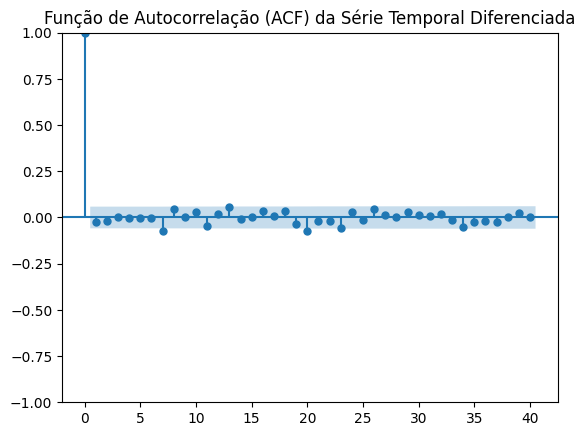

<Figure size 1400x700 with 0 Axes>

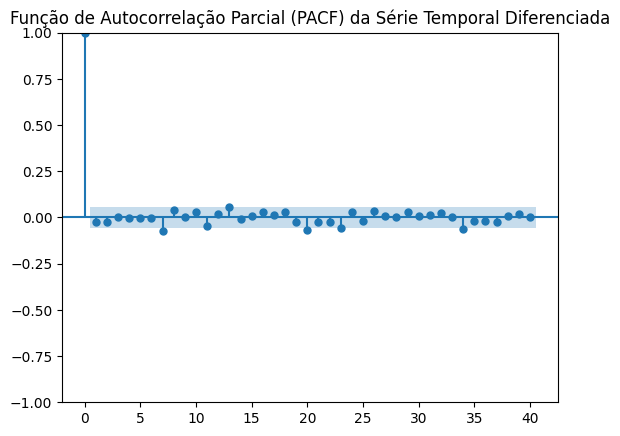

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotando a ACF
plt.figure(figsize=(14, 7))
plot_acf(dados_ibovespa['Último_dif'].dropna(), lags=40)
plt.title('Função de Autocorrelação (ACF) da Série Temporal Diferenciada')
plt.show()

# Plotando a PACF
plt.figure(figsize=(14, 7))
plot_pacf(dados_ibovespa['Último_dif'].dropna(), lags=40)
plt.title('Função de Autocorrelação Parcial (PACF) da Série Temporal Diferenciada')
plt.show()


A observação de que o sétimo lag se situa marginalmente fora do intervalo de confiança, sem apresentar um padrão recorrente (como uma saída do intervalo de confiança a cada sete lags), juntamente com a notável queda na correlação logo após o primeiro lag, traz implicações significativas para a análise da nossa série temporal.<br>
Esta configuração sugere que a série temporal não se caracteriza por um comportamento autorregressivo marcante, ou seja, o valor atual do fechamento não demonstra uma dependência substancial dos valores anteriores. Essa independência relativa entre as observações atuais e as defasagens anteriores é um indicativo de que a série não se beneficia significativamente de um modelo que assume uma relação autorregressiva para fazer previsões precisas.

A concordância deste padrão em ambos os gráficos, ACF e PACF, reforça a ideia de que não apenas os termos autorregressivos, mas também os termos de média móvel, possuem pouca ou nenhuma correlação significativa com a série. Em outras palavras, as flutuações na série temporal parecem não ser explicadas eficientemente nem por suas próprias defasagens (autocorrelação) nem por combinações lineares dos erros passados (média móvel).

Ao retomarmos a análise do primeiro gráfico elaborado para a série temporal, notamos um aspecto particularmente interessante: as séries temporais que representam os valores mínimos, máximos e de abertura do índice exibem um comportamento notavelmente similar à série principal, que contém os valores de fechamento. Este paralelismo entre as duas séries sugere uma correlação significativa nos movimentos de ambos os conjuntos de dados ao longo do tempo<br><br>
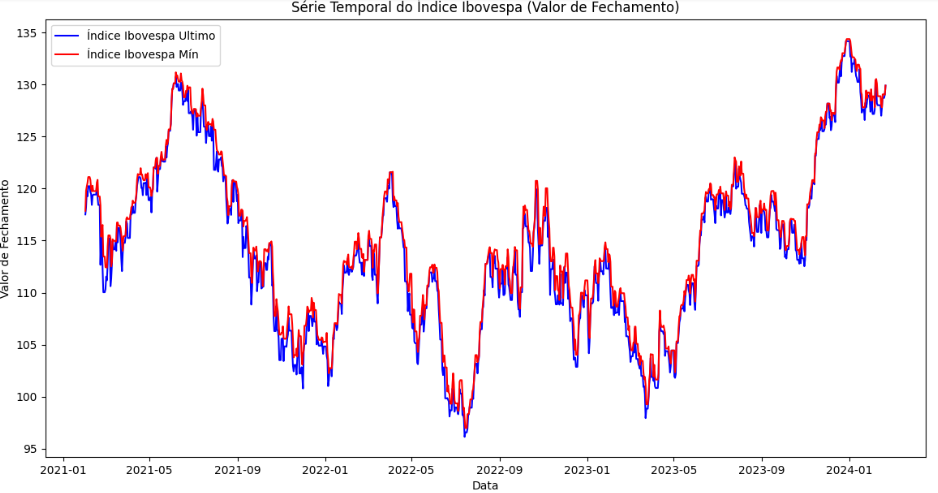


De fato, o valor de fechamento do índice se situa sempre entre o valor mínimo e o máximo do dia e, frequentemente, não se afasta substancialmente do valor de abertura. Essa observação levanta a hipótese intrigante de que a dinâmica da série temporal possa estar mais intimamente relacionada a esses indicadores diários (abertura, mínimo e máximo) do que às suas próprias defasagens anteriores. Tal suposição sugere que os movimentos do índice podem ser mais influenciados por variações intradiárias do que por padrões ou tendências estabelecidos em dias anteriores.<br><br>
Antes de prosseguirmos para testar essa hipótese, é crucial investigar a presença de sazonalidade na série temporal. A sazonalidade refere-se a padrões ou ciclos que se repetem em intervalos regulares dentro dos dados, como variações específicas de dia da semana, mês ou períodos fiscais, que podem influenciar significativamente o comportamento do índice.

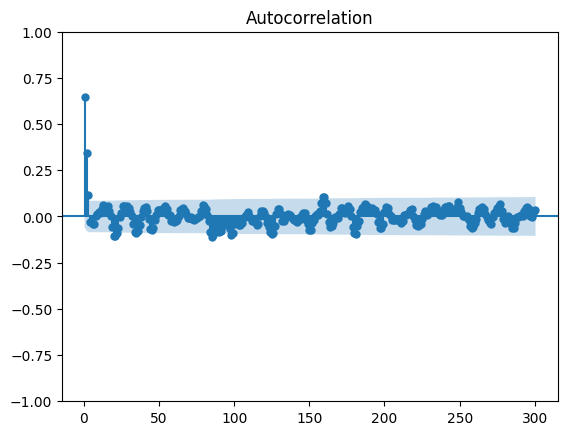

In [ ]:
dados2 = dados_ibovespa[['Último']] - dados_ibovespa[['Último']].rolling(5).mean()
#dados2 = dados_ibovespa[['Último']].diff()
dados2 = dados2.dropna()

fig, ax1 = plt.subplots()

plot_acf(dados2['Último'], lags=300, zero=False, ax=ax1)

plt.show()

Neste estágio da análise, optou-se por uma abordagem alternativa de diferenciação, que consiste na subtração da média móvel dos dados. <br>
Ao aplicar a média móvel como método de diferenciação, atenuamos flutuações de curto prazo e destacamos tendências mais consistentes e prolongadas, permitindo uma análise mais clara da sazonalidade.

A identificação explícita do termo sazonal não se mostrou imediatamente clara. Portanto, adotaremos uma abordagem pragmática inicializando o termo sazonal como 0. Esta decisão serve como um ponto de partida neutro, permitindo uma flexibilidade analítica na modelagem subsequente.

# SARIMAX

## 4. Modelagem

* Instalação da biblioteca pmdarima

In [ ]:
# @title
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00


Para atingir uma acurácia mais acertiva, será utilizada a função auto_arima, que testa diferentes parâmetros para o modelo e seleciona o que apresentar a melhor performance. <br>
Aqui existe um ponto a observar, por mais que a série temporal não apresentou correlação com os lags anteriores, ou seja, não é autoregressiva (o que seria indicado para a escolha de um modelo ARIMA), o modelo escolhido foi o SARIMAX, porque esse consegue lidar com sazonalidades e múltiplas séries como preditoras da principal.

In [ ]:
from pmdarima import auto_arima

# Executando auto_arima para encontrar os melhores parâmetros do modelo SARIMA
modelo_auto_arima = auto_arima(dados_ibovespa['Último'],
                               seasonal=False,
                               #m=5,  # substitua por sua periodicidade sazonal conhecida
                               d=1,
                               D=1,  # valores comuns para começar
                               max_p=3, max_q=3, max_P=3, max_Q=3,  # valores máximos para os parâmetros
                               trace=True,  # para imprimir o progresso enquanto o modelo está sendo ajustado
                               error_action='ignore',  # não queremos que pare em caso de erro
                               suppress_warnings=True,  # suprimir avisos de modelos que não convergiram
                               stepwise=True)  # algoritmo stepwise

# Melhores parâmetros encontrados
print(modelo_auto_arima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3458.093, Time=3.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3451.382, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3452.672, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3452.639, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3449.494, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3454.175, Time=2.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.692 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1117
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1723.747
Date:                Wed, 28 Feb 2024   AIC                           3449.494
Time:                        01:11:33   BIC                           3454.512
Sample:                    02-01-2021   HQIC                          3451.391
          

A função auto_arima confirmou que a série não possui correlação com os lags anteriores, já que foi recomendado o valor 0 para p e para q SARIMAX(0, 1, 0), com 1 termo de diferenciação

## 5. Resultados

* Instalação da biblioteca statsmodels

In [ ]:
# @title
!pip install statsmodels

Para avaliar a eficácia do nosso modelo, será utilizada a função mape (Mean Absolute Percentage Error), que quantifica o erro absoluto médio percentual das previsões. Quanto menor é o valor dessa função, mais o modelo está acertando. Nosso alvo é alcançar um erro não superior a 30%

In [ ]:
# Adicionado uma pequena constante ao denominador para evitar divisão por zero
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

O modelo será treinado sem parâmetros de sazonalidade, isso porque já foi visto na análise exploratória que os termos não apresentaram correlação.<br>
80% da base será utilizada como treino e 20% como teste.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Y é a variável alvo
# x contém as séries que foram consideradas preditoras
y = dados_ibovespa['Último']
x = dados_ibovespa[['Abertura','Mínima','Máxima']]

# Divisão do dataset em treinamento e teste
# 80% para treino e 20% para teste (apresentou a média de erro mais baixa)
#n = len(dados_ibovespa)
n = len(y)
#train = dados_ibovespa.iloc[:int(n*0.90)]
#test = dados_ibovespa.iloc[int(n*0.90):]
train_y = y.iloc[:int(n*0.80)]
test_y = y.iloc[int(n*0.80):]
train_x = x.iloc[:int(n*0.80)]
test_x = x.iloc[int(n*0.80):]

#train_y = y.iloc[:int(n)]
#train_x = x.iloc[:int(n)]
# Ajuste o modelo SARIMA aos dados de treinamento
modelo_sarima = SARIMAX(train_y,
                        exog=train_x,
                        order=(0, 1, 0),
                        #seasonal_order=(3, 1, 0, 5),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

resultado_sarima = modelo_sarima.fit()

# Previsões do modelo
#previsoes = resultado_sarima.get_forecast(steps=3, exog=exog)
previsoes = resultado_sarima.get_forecast(steps=len(test_y), exog=test_x)
previsoes_conf_int = previsoes.conf_int()

# Calcular o MAPE da previsão
#mape = np.mean(np.abs(previsoes.predicted_mean - test['Último']) / np.abs(test['Último'])) * 100
mape = calculate_mape(test_y, previsoes.predicted_mean)

#print(f'Previsão MAPE: {mape}%')

print(f'Modelo SARIMA ajustado')
print(f'Previsão MAPE: {mape}%')

# Se o MAPE for menor que 30, então a acurácia é maior que 70%


Modelo SARIMA ajustado
Previsão MAPE: 1.3894625503480058%


Conforme a análise fornecida pela métrica MAPE (Mean Absolute Percentage Error), o modelo demonstrou uma média de erro baixa, o que sinaliza um desempenho notavelmente positivo nas previsões realizadas. Tal eficácia, embora promissora, pode também levantar a possibilidade de overfitting — uma condição na qual o modelo se ajusta demasiadamente aos dados de treinamento, comprometendo sua capacidade de generalizar para novos conjuntos de dados.

Antes disso, observe o modelo escolhido:<br><br>
modelo_sarima = SARIMAX(train_y,<br>
                        exog=train_x,<br>
                        order=(0, 1, 0),<br>
                        enforce_stationarity=False,
                        enforce_invertibility=False)<br><br>
o parâmetro exog recebe as séries que influenciam o valor da série principal;<br>

Agora, comparando os dados previstos com os dados de teste, nota-se o seguinte:

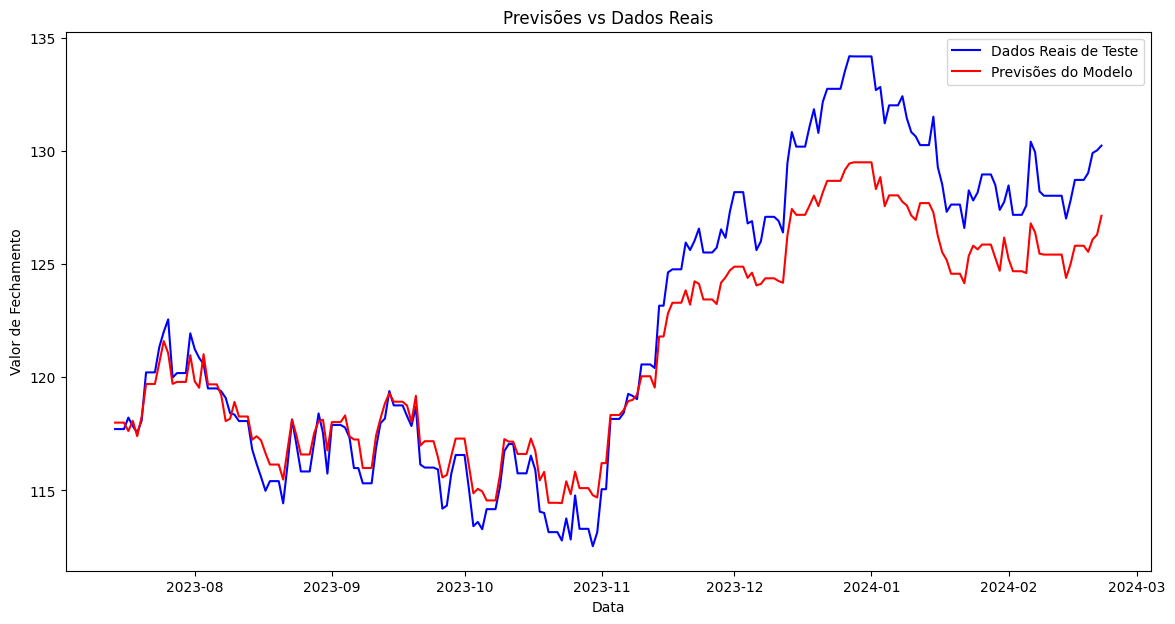

In [ ]:
import matplotlib.pyplot as plt

# Plotando os dados reais de teste
plt.figure(figsize=(14,7))
plt.plot(test_y.index, test_y, color='blue', label='Dados Reais de Teste')

# Plotando as previsões
# previsoes.predicted_mean contém os valores previstos
plt.plot(test_y.index, previsoes.predicted_mean, color='red', label='Previsões do Modelo')

# Preencher o intervalo de confiança, se desejado
#plt.fill_between(test.index,
                # previsoes_conf_int.iloc[:, 0],
                 #previsoes_conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Previsões vs Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()


Observa-se que a possibilidade de o modelo ter memorizado os dados de treinamento é considerada baixa, dado que estamos trabalhando com um conjunto de dados extenso e real, abrangendo datas a partir de 2021. Adicionalmente, embora as previsões geradas pelo modelo não sejam idênticas aos valores reais, elas apresentam uma aproximação notável. Isso sugere que, apesar da elevada precisão observada, o modelo conseguiu capturar a tendência geral dos dados sem incorrer em overfitting.

É possível que o uso de uma métrica de erro diferente pudesse resultar em uma porcentagem de erro superior à obtida por meio do MAPE (Mean Absolute Percentage Error), embora ainda se esperasse que o resultado permanecesse dentro de uma faixa considerada aceitável.

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(test_y, previsoes.predicted_mean, squared=False)

print(rmse)

2.2019098670647015


Conforme antecipado, a aplicação da métrica RMSE (Raiz do Erro Quadrático Médio) resultou em um valor de erro mais elevado em comparação ao obtido através do MAPE. Esse resultado era esperado, dada a natureza distinta das duas métricas na avaliação do desempenho de modelos preditivos.

# PROPHET

O modelo SARIMAX funcionou bem, mas precisou de variáveis exógenas. Agora, será testado o PROPHET, que é um procedimento para previsão de dados de séries temporais com base em um modelo aditivo onde tendências não lineares são ajustadas à sazonalidade anual, semanal e diária, além dos efeitos dos feriados, de acordo com a própria documentação disponível no link https://facebook.github.io/prophet/

## Modelagem

In [ ]:
# @title
!pip install prophet

Para o treinamento do modelo utilizando o PROPHET, é necessário formatar as variáveis de maneira específica: 'ds' deve ser utilizada para representar as datas, enquanto 'y' é destinada ao valor que se deseja prever, neste contexto referido como 'último'.

In [ ]:
df_data = dados_ibovespa.reset_index()
df = pd.DataFrame()
df[['ds', 'y']] = df_data[['Data', 'Último']]
df.head()

Após a análise inicial, procederemos com a separação dos dados em conjuntos de treino e teste. Será adotada a estratégia de utilizar 80% dos dados disponíveis para o treinamento do modelo. Essa abordagem visa assegurar que o modelo tenha uma quantidade significativa de informações históricas para aprender as tendências, padrões e sazonalidades inerentes à série temporal em questão, otimizando assim a precisão das previsões geradas.

In [ ]:
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

Após a separação dos dados em conjuntos de treino e teste, realizaremos a previsão para os próximos 30 dias, começando a partir da última data dos dados de treino. Para isso, o método make_future_dataframe será empregado para criar um DataFrame que abrange esse período futuro desejado.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbgs0bpz9/6exmw9zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbgs0bpz9/5y1qli5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89776', 'data', 'file=/tmp/tmpbgs0bpz9/6exmw9zg.json', 'init=/tmp/tmpbgs0bpz9/5y1qli5p.json', 'output', 'file=/tmp/tmpbgs0bpz9/prophet_modelxwb9jy00/prophet_model-20240311031511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


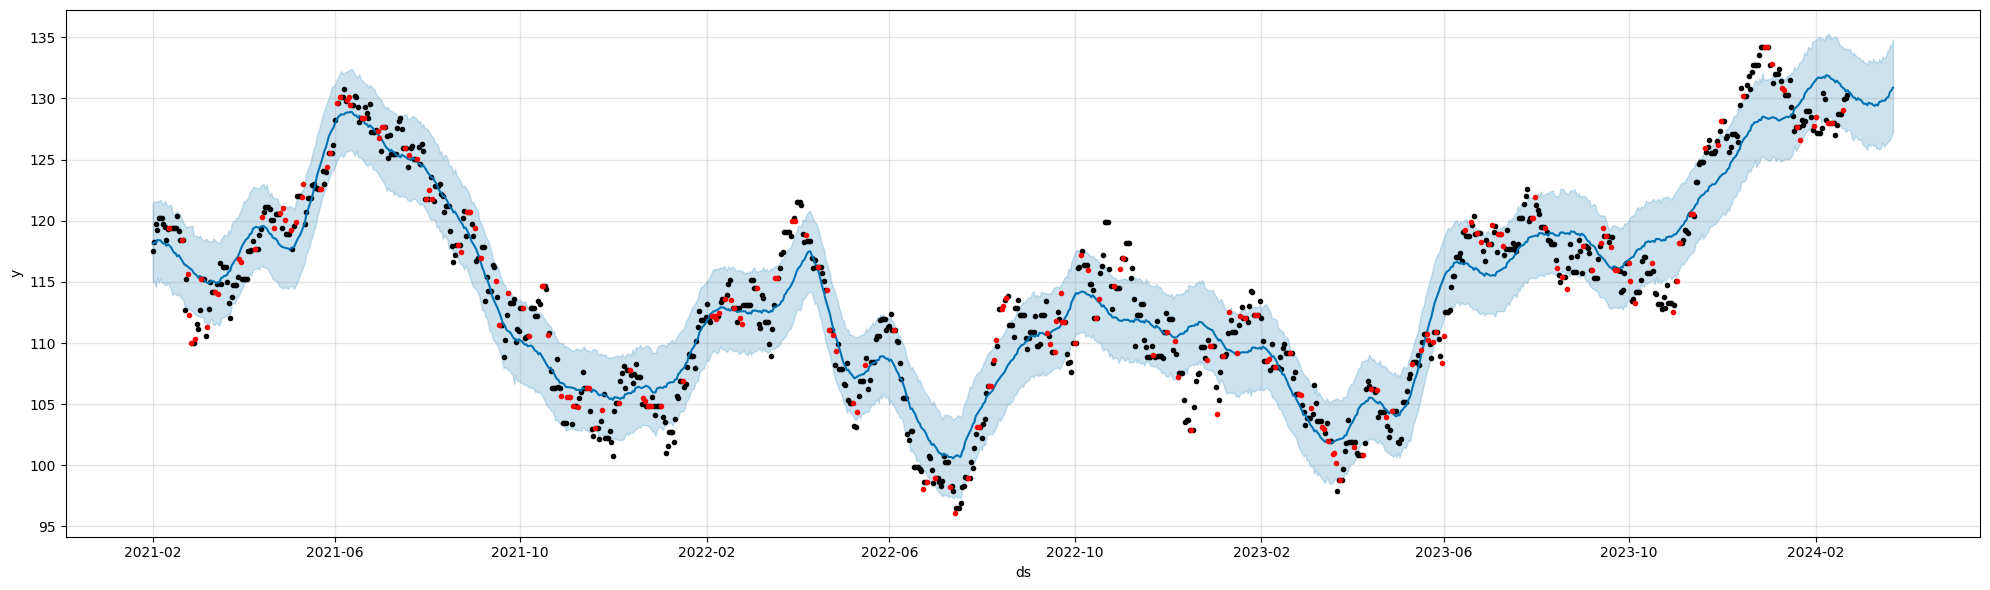

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(train)
dataFramefuture = modelo_prophet.make_future_dataframe(periods=30, freq='D')
previsao = modelo_prophet.predict(dataFramefuture)

modelo_prophet.plot(previsao, figsize=(20,6));
plt.plot(test['ds'], test['y'], '.r')


Na imagem acima, os pontos vermelhos são os dados de teste. Vamos agora fazer o cálculo do erro médio.

In [ ]:
import numpy as np

previsao = previsao[['ds', 'yhat']]
valores_reais = df[['ds', 'y']]

# Os dataframes serão mesclados pela coluna 'ds' para que os
# resultados sejam comparados
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro médio
mape = calculate_mape(resultados['y'], resultados['yhat'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.83%


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(resultados['y'], resultados['yhat'], squared=False)

print(rmse)

2.585046690308639


Ao analisar os resultados das métricas de erro, observa-se que o modelo demonstrou boa precisão, o que reforça a eficácia do PROPHET como uma ferramenta robusta e de fácil aplicação. Diferentemente do modelo SARIMAX, que exige ajustes detalhados de parâmetros e potencial tratamento dos dados, o PROPHET destaca-se pela sua simplicidade operacional, não necessitando de procedimentos complexos de configuração ou preparação dos dados para alcançar resultados satisfatórios.

## 6. Conclusão e Recomendações

Chegamos ao término de nossa jornada analítica com resultados promissores e insights valiosos sobre a previsão do fechamento diário da IBOVESPA. Os modelos desenvolvidos ao longo deste projeto demonstraram uma capacidade notável de prever o valor de fechamento do índice com uma porcentagem de erro baixa. Este sucesso sublinha o potencial do modelo para ser uma ferramenta valiosa na caixa de ferramentas de investidores e analistas financeiros.


Importante ressaltar que, no caso do SARIMAX, os valores exatos de mínimo e máximo de um índice são definitivamente estabelecidos apenas após o encerramento das operações diárias na bolsa de valores. No entanto, obter estimativas precisas desses valores em tempo real, durante o horário de negociação, é perfeitamente viável. Também é possível fazer essa tarefa de forma automatizada, mas isso está fora do escopo do modelo desenvolvido. Ademais, como alternativa mais simples, é possível estimar esses valores considerando a variação média diária. Essa técnica permite uma aproximação razoável dos valores extremos que o índice pode alcançar ao longo do dia de negociação.